<a href="https://colab.research.google.com/github/nicolasquant/Cases/blob/main/Case_Kinea/Case_Kinea_Nicolas_Cenedesi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Parte I - Fluxo NTN-B (Com Juros Semestral) + Duration De Macaulay

1 - O código a seguir foi desenvolvido de maneira didática, realizando os processos passo a passo. Computacionalmente, o código não possui eficiencia extrema, mas o passo a passo o torna mais organizado e didatico.

2 -

###Introdução

Na realizacao da compra de um titulo publico do tipo NTN-B com juros semestrais, há um fluxo de caixa definido por pagamentos semestrais (cupons), PU (valor a ser pago pelo titulo) e o principal (valor esse a ser recebido no ultimo periodo de recebimento do titulo, junto ao último cupom).

No código a seguir, iremos realizar a precificação do título público (obtenção do PU) a partir de algumas variáveis definidas (inputs), como: a taxa real, taxa de cupom, inflação, Valor Nominal Ajustado (VNA) e prazo de vencimento do título.

Vale ressaltar que o código a seguir possibilita a adição dessas variáveis de forma manual, adequando-o a qualquer aplicaçaõ voltada à precificação de títulos semelhantes ao NTN-B.

Por fim, realizaremos o cálculo da Duration de Macaulay


###Definição das Variáveis primárias

Possuímos 5 inputs obrigatórios para realizar o cálculo do PU de um NTN-B, dentre eles:

$VNA_db$ = Valor Nominal Atualizado na data-sabe (no caso do nosso codigo, nossa data base será referente ao mes 09/2025 onde possui o valor de emissao do titulo já atualizado pela inflacao , porém, a real data base, ou seja, a data de criação do título foi em 15 de Julho de 2000)

$IPCA$ = inflação projetada

$T$ = prazo de vencimento do título

$c$ = taxa de cupom do título (no caso do NTN-B, essa taxa é de 6% a.a)

$r$ = taxa real (define o retorno exigido pelo comprador do título e pode variar diariamente dependendo da cotacao do mercado)


## Variáveis Essenciais para a Precificação da NTN-B

Para calcular o Preço Unitário (PU) de uma NTN-B, o modelo exige estas cinco variáveis principais de entrada.

| Variável | Símbolo no Cálculo | Descrição | Exemplo de Valor |
| :---: | :---: | :--- | :---: |
| **VNA na Compra** | $VNA_{t=0}$ | O **Valor Nominal Atualizado** na data de hoje ($t=0$). É a base da dívida já corrigida pela inflação histórica, usada para iniciar o cálculo. | R\$ 4.535,99 |
| **Inflação Projetada** | $\pi$ | A taxa média anual de inflação esperada (IPCA) para o período restante de vida do título. | $4,65\%$ a.a. |
| **Prazo** | $T$ | O tempo restante, em anos, até o vencimento e resgate do principal. | 10 anos |
| **Taxa de Cupom** | $c$ | A taxa fixa e contratual (**$6,00\%$ a.a.**) usada para calcular o valor dos pagamentos de juros semestrais. | $6,00\%$ a.a. |
| **Taxa Real** | $r$ | A **Taxa de Retorno (Yield)** exigida pelo mercado, acima da inflação. **Varia diariamente** e define o preço (PU). | $7,64\%$ a.a. |

### Nota sobre a Base de Cálculo:

O valor $\mathbf{VNA_{t=0}}$ que usamos no código já inclui a correção da inflação histórica. A **data de origem real** (marco zero) para o índice VNA é 15 de Julho de 2000, onde o valor era de R\$ 1.000,00.

---


In [2]:
# ----------------------------------------------------
#               INPUTS VARIÁVEIS PRIMARIAS
# ----------------------------------------------------

# INPUT 1: Taxa Real de Juros Desejada (a.a.)
taxa_real_anual = 0.0764  # 7,64% ao ano ( note que ao aumental a taxa, diminuimos o PU final, sera que isso ta certo?) --- sim, esta correto, isso acontece por conta da diminuicao do valor presente consequente da elevacao da taxa real.

# INPUT 2: Prazo de Vencimento (em anos)
prazo_vencimento_em_anos = 10  # 10 anos (20 semestres)

# INPUT 3: IPCA
IPCA_proj_anual = 0.0465 # 4,65% ao ano --- note que a alteracao da inflacao nao altera o PU final (sera que isso ta certo)

# INPUT 4: Taxa de Cupom (Definida pelo título)
taxa_cupom_anual = 0.06 # 6% a.a.

# VNA Inicial (Manter valor para t=0)
vna_inicial = 4535.996085

## Definição das variáveis secundárias

As variáveis secundárias seriam aquelas dependentes das variáveis primárias antes definidas.
Em um cenario geral, as taxas convencionais sao definidas anualmente, porém, para um fluxo de caixa semestral, como o que ocorre na compra de um NTN-B com juros semestral, devemos realizar a conversao das três taxas: IPCA, taxa real, taxa de cupom para periodo semestral.
Além disso, devemos definir uma quarta variavel secundária, chamada de Taxa Nominal de Desconto Semestral (Fórmula de Fisher)




## Variáveis Secundárias (Derivadas no Código)

As variáveis secundárias são aquelas dependentes das variáveis primárias (inputs) e são calculadas internamente pelo modelo para ajustar as taxas ao período semestral e encontrar a taxa de desconto correta.

Em um cenário geral, as taxas convencionais são definidas anualmente. No entanto, para um fluxo de caixa semestral, como o que ocorre na NTN-B, devemos realizar a conversão das três taxas primárias: $\pi$ (IPCA), $r$ (Taxa Real), e $c$ (Taxa de Cupom).

| Variável | Símbolo no Cálculo | Descrição | Fórmula Base |
| :--- | :---: | :--- | :---: |
| **Períodos Totais** | $N$ | Número total de pagamentos (semestres) até o vencimento. | $N = T \times 2$ |
| **Inflação Semestral** | $\pi_{sem}$ | A inflação projetada ($\pi$) convertida para o período de capitalização semestral. | $\pi_{sem} = (1 + \pi)^{1/2} - 1$ |
| **Taxa Real Semestral** | $r_{sem}$ | A taxa real exigida ($r$) convertida para o período de capitalização semestral. | $r_{sem} = (1 + r)^{1/2} - 1$ |
| **Taxa Cupom Semestral** | $c_{sem}$ | A taxa de cupom anual ($c$) convertida para a taxa de pagamento semestral. | $c_{sem} = (1 + c)^{1/2} - 1$ |
| **Taxa Nominal de Desconto** | $i_{nom}$ | A **Taxa de Desconto (Custo de Oportunidade)**. Combina o retorno real e a inflação (Fórmula de Fisher). | $i_{nom} = (1 + r_{sem})(1 + \pi_{sem}) - 1$ |

In [3]:
# ----------------------------------------------------
#               CÁLCULO VARIÁVEIS SECUNDÁRIAS
# ----------------------------------------------------

# 1. Parâmetros do Tempo
periodos_vencimento_semestres = prazo_vencimento_em_anos * 2

# 2. Taxas Semestrais
# Taxa Real Semestral
taxa_real_semestral = (1 + taxa_real_anual)**0.5 - 1
# Inflação Semestral
IPCA_semestral = (1 + IPCA_proj_anual)**0.5 - 1
# Taxa Nominal de Desconto Semestral (Fórmula de Fisher)
taxa_nominal_semestral = (1 + taxa_real_semestral) * (1 + IPCA_semestral) - 1

# Cupom Semestral (%)
cupom_semestral_pct = (1 + taxa_cupom_anual)**0.5 - 1

###Cálculo do Preço Unitário


O **Preço Unitário (PU)** é o valor de mercado que o comprador deve pagar hoje ($t=0$) por um título. Ele é o preço de equilíbrio que garante que o comprador receberá o **Retorno Real ($r$) exigido**, considerando-se o valor nominal atualizado do ativo ($VNA_{t=0}$), a **inflação projetada ($\pi$)**, a taxa de cupom ($c$) e o prazo de vencimento ($T$).

O PU flutua no mercado para ajustar a rentabilidade do título à taxa exigida no dia.


Matematicamente, o Preço Unitário é a soma dos **Valores Presentes ($VP_t$)** de todos os pagamentos futuros (fluxos de caixa nominais) do título:

$$PU = \sum_{t=1}^{N} VP_t$$

**Onde:**

* **$VP_t$** é o Valor Presente do fluxo de caixa no período $t$.
* **$N$** é o número total de períodos (semestres) até o vencimento.

Onde $VP_t = \frac{FC_{Nominal, t}}{(1 + i_{nom})^t}$.

$PU$	Preço Unitário Atual do título (nosso foco)

$VP_t$ = Valor Presente do fluxo de caixa no semestre t.

$VNA_t$ = Valor Nominal Atualizado no semestre t (reajustado pela inflação semestral).


$FC_Nominal$	Fluxo de Caixa Nominal Total no semestre t (Jt​+Pt​).


## 4. Fluxo de Caixa Nominal ($FC_{Nominal, t}$)

Dentre todos os valores, o **Fluxo de Caixa Nominal** ($FC_{Nominal, t}$) é a única variável que precisamos calcular para cada semestre.

O $FC_{Nominal, t}$ representa o valor em Reais que o investidor irá **receber** no período $t$. Ele é composto pelo pagamento do cupom de juros e, no vencimento, pela devolução do principal.

A fórmula que define o Fluxo de Caixa Nominal da NTN-B no semestre $t$ é:

$$FC_{Nominal, t} = \left( VNA_t \times c_{sem} \right) + P_t$$ ou
$$FC_{Nominal, t} = J_t + P_t$$

**Onde:**

* **$VNA_t$** É o **Valor Nominal Atualizado** no semestre $t$ (o VNA corrigido pela inflação acumulada até o período).
* **$c_{sem}$** É a **Taxa de Cupom Semestral** (o $6,00\%$ a.a. convertido).
* **$P_t$** É o **Pagamento do Principal**, sendo $P_t = 0$ para todos os períodos, exceto no vencimento ($t=N$), onde $P_t = VNA_t$.
* $J_t$	Pagamento do Cupom Nominal no semestre t.

In [12]:
import numpy as np
import matplotlib.pyplot as plt


def calcular_pu_ntnb(taxa_real_semestral, prazo_semestres, vna_inicial, inflacao_projetada_semestral, cupom_anual=0.06):
    """
    Calcula o Preço Unitário (PU) de uma NTN-B (Tesouro IPCA com Juros Semestrais).

    Args:
        taxa_real_anual (float): Taxa real de juros desejada (a.a.), ex: 0.05 para 5%.
        prazo_anos (int): Prazo até o vencimento em anos.
        inflacao_projetada_anual (float): Inflação (IPCA) projetada (a.a.), ex: 0.04.
        vna_inicial (float): Valor Nominal Atualizado inicial de referência. Nesse caso, pegamos o VNA inicial de referencia
        cupom_anual (float): Taxa de cupom anual da NTN-B (padrão é 0.06).

    Returns:
        float: O Preço Unitário (PU) atual do título.
    """

    # Inicializa o PU , VNA e o principal
    pu_atual = 0.0
    vna_atual = vna_inicial
    principal = 0.0

    # --- Tabela de Fluxo de Pagamentos ---
    print("\n--- Fluxo de Pagamentos (Valores Nominais) ---")
    print(f"{'Período (Semestre)':<20} | {'VNA Atualizado (R$)':<20} | {'Cupom (R$)':<15} | {'Principal (R$)':<15} | {'FC Total (R$)':<15} | {'Valor Presente (R$)':<20}")
    print("-" * 130)

    # 3. Cálculo do Fluxo e do PU
    for t in range(1, periodos_vencimento_semestres + 1):

        # 3.1. Atualização do VNA (pela inflação)
        # O VNA é atualizado a cada período pela inflação projetada
        vna_atual *= (1 + IPCA_semestral)

        # 3.2. Fluxo de Caixa do Período
        cupom_nominal = vna_atual * cupom_semestral_pct

        # O pagamento do principal (VNA final) ocorre apenas no último período
        if t == periodos_vencimento_semestres:
            principal = vna_atual

        fluxo_caixa_total = cupom_nominal + principal

        # 3.3. Desconto a Valor Presente
        # O fluxo nominal é descontado pela taxa nominal semestral
        fator_desconto = (1 + taxa_nominal_semestral)**t # usamos essa eq pra trazer os cupons a valor presente.
        valor_presente = fluxo_caixa_total / fator_desconto

        # 3.4. Acumula o PU
        pu_atual += valor_presente

        # Exibe a linha do fluxo (opcional, mas útil para conferência)
        print(f"{t:<20} | {vna_atual:<20.2f} | {cupom_nominal:<15.2f} | {principal:<15.2f} | {fluxo_caixa_total:<15.2f} | {valor_presente:<20.2f}")

    return pu_atual

# ----------------------------------------------------
#               EXECUÇÃO
# ----------------------------------------------------

pu_resultado = calcular_pu_ntnb(
    taxa_real_semestral=taxa_real_semestral,
    prazo_semestres=periodos_vencimento_semestres,
    vna_inicial=vna_inicial,
    inflacao_projetada_semestral=IPCA_semestral
)

# ----------------------------------------------------
#               OUTPUT FINAL
# ----------------------------------------------------

print("\n" + "=" * 50)
print(f"Taxa Real de Juros semestral (Input): {taxa_real_semestral*100:.2f}%")
print(f"Prazo de Vencimento (Input): {periodos_vencimento_semestres} semestres")
print("-" * 50)
print(f"**Preço Unitário (PU) Atual do Título:** R$ {pu_resultado:.2f}")
print("=" * 50)


--- Fluxo de Pagamentos (Valores Nominais) ---
Período (Semestre)   | VNA Atualizado (R$)  | Cupom (R$)      | Principal (R$)  | FC Total (R$)   | Valor Presente (R$) 
----------------------------------------------------------------------------------------------------------------------------------
1                    | 4640.26              | 137.18          | 0.00            | 137.18          | 129.25              
2                    | 4746.92              | 140.33          | 0.00            | 140.33          | 124.58              
3                    | 4856.03              | 143.56          | 0.00            | 143.56          | 120.08              
4                    | 4967.65              | 146.86          | 0.00            | 146.86          | 115.74              
5                    | 5081.84              | 150.23          | 0.00            | 150.23          | 111.55              
6                    | 5198.65              | 153.69          | 0.00            | 153.69       

In [13]:
def calcular_pu_ntnb(taxa_real_semestral, prazo_semestres, inflacao_projetada_anual, vna_inicial, cupom_anual):
    """
    Calcula o Preço Unitário (PU) e gera o Fluxo de Caixa Completo para plotagem.

    Retorna: (PU_atual, periodos_com_t0, fluxo_caixa_completo)
    """

    # Inicializa o PU e o VNA
    pu_atual = 0.0
    vna_atual = vna_inicial

    # Lista para capturar o fluxo nominal futuro (FC_t)
    fluxos_caixa_futuros = []

    # --- Tabela de Fluxo de Pagamentos ---
    print("\n--- Fluxo de Pagamentos (Valores Nominais) ---")
    print(f"{'Período (Semestre)':<20} | {'VNA Atualizado (R$)':<20} | {'Cupom (R$)':<15} | {'Principal (R$)':<15} | {'FC Total (R$)':<15} | {'Valor Presente (R$)':<20}")
    print("-" * 130)

    # 3. Cálculo do Fluxo e do PU
    for t in range(1, prazo_semestres + 1):

        # 3.1. Atualização do VNA (pela inflação)
        vna_atual *= (1 + IPCA_semestral)

        # 3.2. Fluxo de Caixa do Período
        cupom_nominal = vna_atual * cupom_semestral_pct
        principal = 0.0

        # O pagamento do principal (VNA final) ocorre apenas no último período
        if t == prazo_semestres:
            principal = vna_atual

        fluxo_caixa_total = cupom_nominal + principal

        # 3.3. Desconto a Valor Presente
        fator_desconto = (1 + taxa_nominal_semestral)**t
        valor_presente = fluxo_caixa_total / fator_desconto

        # 3.4. Acumula o PU
        pu_atual += valor_presente

        # CAPTURA DO FLUXO NOMINAL PARA PLOTAGEM
        fluxos_caixa_futuros.append(fluxo_caixa_total)

        # Exibe a linha do fluxo (opcional, mas útil para conferência)
        print(f"{t:<20} | {vna_atual:<20.2f} | {cupom_nominal:<15.2f} | {principal:<15.2f} | {fluxo_caixa_total:<15.2f} | {valor_presente:<20.2f}")

    # 4. PREPARAÇÃO DO FLUXO DE CAIXA COMPLETO

    # Períodos: 0 (PU), 1, 2, ..., N
    periodos_com_t0 = [0] + list(range(1, prazo_semestres + 1))

    # Fluxo: [ -PU (saída), FC1, FC2, ..., FCN (entradas) ]
    fluxo_caixa_completo = [-pu_atual] + fluxos_caixa_futuros

    return pu_atual, periodos_com_t0, fluxo_caixa_completo


# ----------------------------------------------------
#               OUTPUT FINAL - EXECUÇÂO
# ----------------------------------------------------

# Executa a função adaptada que retorna o PU e as listas para o gráfico
pu_resultado, periodos, fluxos = calcular_pu_ntnb(
    taxa_real_semestral=taxa_real_semestral,
    prazo_semestres=periodos_vencimento_semestres,
    inflacao_projetada_anual=IPCA_semestral, # NOTE: Parâmetro IPCA_proj_anual é na verdade semestral aqui
    vna_inicial=vna_inicial,
    cupom_anual=taxa_cupom_anual
)

print("\n" + "=" * 50)
print(f"Taxa Real Anual (r): {taxa_real_anual*100:.2f}%")
print(f"Inflação Projetada (π): {IPCA_proj_anual*100:.2f}%")
print("-" * 50)
print(f"**Preço Unitário (PU) Atual do Título:** R$ {pu_resultado:.2f} (Saída em t=0)")
print("=" * 50)


--- Fluxo de Pagamentos (Valores Nominais) ---
Período (Semestre)   | VNA Atualizado (R$)  | Cupom (R$)      | Principal (R$)  | FC Total (R$)   | Valor Presente (R$) 
----------------------------------------------------------------------------------------------------------------------------------
1                    | 4640.26              | 137.18          | 0.00            | 137.18          | 129.25              
2                    | 4746.92              | 140.33          | 0.00            | 140.33          | 124.58              
3                    | 4856.03              | 143.56          | 0.00            | 143.56          | 120.08              
4                    | 4967.65              | 146.86          | 0.00            | 146.86          | 115.74              
5                    | 5081.84              | 150.23          | 0.00            | 150.23          | 111.55              
6                    | 5198.65              | 153.69          | 0.00            | 153.69       

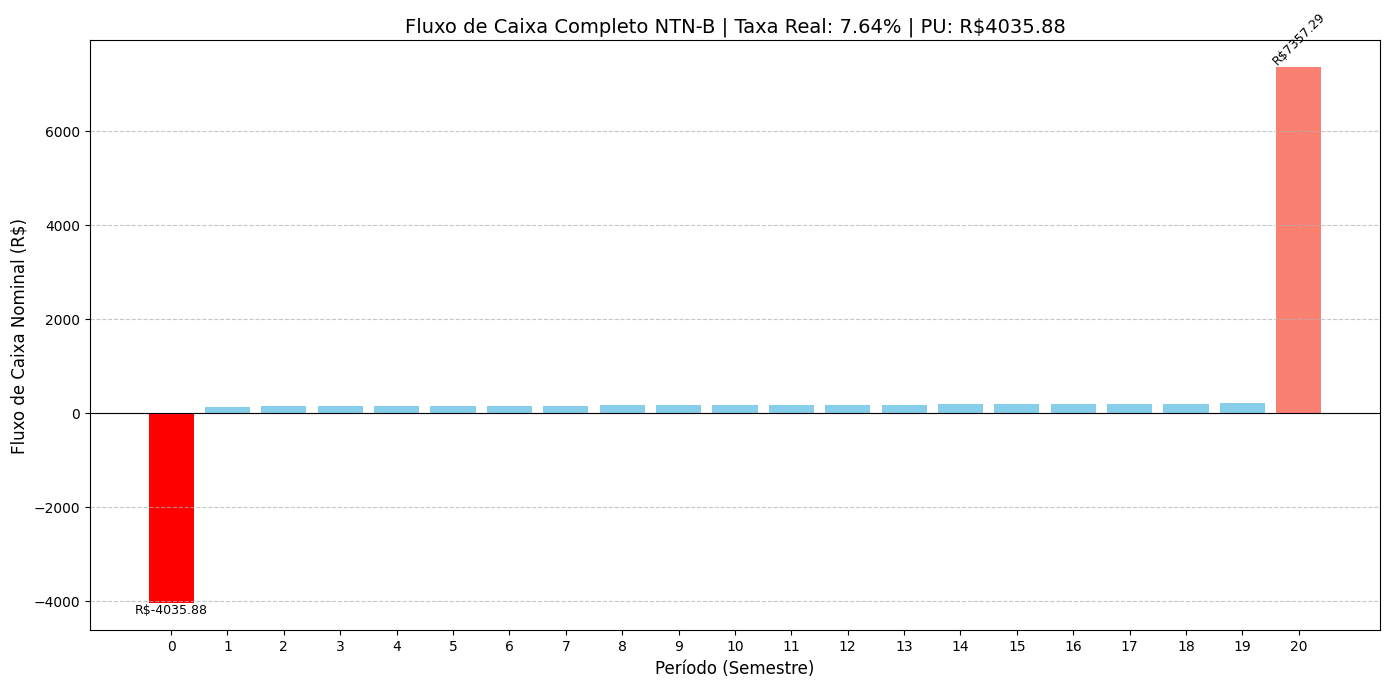

In [14]:
# ----------------------------------------------------
#              PLOTAGEM DO FLUXO DE CAIXA
# ----------------------------------------------------

# --- Geração do Gráfico ---
plt.figure(figsize=(14, 7))
bars = plt.bar(
    periodos,
    fluxos,
    # Define as cores: Vermelho para t=0 (saída), Salmão para o vencimento, Azul para os cupons
    color=['red'] + ['skyblue'] * (len(fluxos) - 2) + ['salmon']
)

# Configurações do Gráfico
plt.xlabel('Período (Semestre)', fontsize=12)
plt.ylabel('Fluxo de Caixa Nominal (R$)', fontsize=12)
plt.title(
    f'Fluxo de Caixa Completo NTN-B | Taxa Real: {taxa_real_anual*100:.2f}% | PU: R${pu_resultado:.2f}',
    fontsize=14
)
# Linha zero para visualizar claramente a saída (t=0) e as entradas
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(periodos)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adicionar rótulos para o PU e o último fluxo
if fluxos:
    # Rótulo para o PU (Investimento, t=0)
    plt.text(periodos[0], fluxos[0], f'R${fluxos[0]:.2f}', ha='center', va='top', fontsize=9, color='black')
    # Rótulo para o Vencimento (maior entrada)
    last_flow = fluxos[-1]
    plt.text(periodos[-1], last_flow, f'R${last_flow:.2f}', ha='center', va='bottom', fontsize=9, rotation=45)

plt.tight_layout()
plt.show()

###Duration de Macaulay

A Duration de Macaulay é a média ponderada do tempo para receber esses fluxos, calculada em semestres e convertida para anos:


$$D_{Mac} \text{ (semestres)} = \frac{\sum_{t=1}^{N} t \times VP_t}{PU}$$

$DMac$ Duration de Macaulay (em anos).

In [6]:
import numpy as np

def calcular_pu_e_duration_ntnb(taxa_real_anual, prazo_anos, inflacao_projetada_anual=0.04, vna_inicial=1000.0, cupom_anual=0.06):
    """
    Calcula o Preço Unitário (PU) e a Duration de Macaulay de uma NTN-B.

    Args:
        taxa_real_anual (float): Taxa real de juros desejada (a.a.), ex: 0.05 para 5%. -- retorno exigido, vulgo taxa yield
        prazo_anos (int): Prazo até o vencimento em anos.
        inflacao_projetada_anual (float): Inflação (IPCA) projetada (a.a.), ex: 0.04.
        vna_inicial (float): Valor Nominal Atualizado inicial de referência.
        cupom_anual (float): Taxa de cupom anual da NTN-B (padrão é 0.06).

    Returns:
        tuple: (PU_atual, duration_macaulay_anos)
    """

    # 1. Parâmetros do Tempo
    periodos_semestres = prazo_anos * 2

    # 2. Taxas Semestrais - conversao de taxas anuais pra taxa semestrais
    taxa_real_semestral = (1 + taxa_real_anual)**0.5 - 1
    inflacao_semestral = (1 + inflacao_projetada_anual)**0.5 - 1
    # Taxa Nominal de Desconto Semestral (Fórmula de Fisher) - ou valor de oportunidade
    taxa_nominal_semestral = (1 + taxa_real_semestral) * (1 + inflacao_semestral) - 1

    cupom_semestral_pct = (1 + cupom_anual)**0.5 - 1

    # Inicializa variáveis
    pu_atual = 0.0
    vna_atual = vna_inicial
    # Variável para a Duration: Soma ponderada dos VPs
    soma_vp_ponderado_pelo_tempo = 0.0

    # --- Tabela de Fluxo de Pagamentos ---
    print("\n--- Fluxo de Pagamentos e Ponderação para Duration ---")
    cabecalho = (
        f"{'Período (Semestre)':<20} | {'VNA Atualizado (R$)':<20} | {'Cupom (R$)':<15} | "
        f"{'Principal (R$)':<15} | {'FC Total (R$)':<15} | {'Valor Presente (VP) (R$)':<25} | "
        f"{'VP * Tempo (R$)':<20}"
    )
    print(cabecalho)
    print("-" * len(cabecalho))

    # 3. Cálculo do Fluxo, PU e Ponderação
    for t in range(1, periodos_semestres + 1):

        # 3.1. Atualização do VNA (pela inflação)
        vna_atual *= (1 + inflacao_semestral)

        # 3.2. Fluxo de Caixa do Período
        cupom_nominal = vna_atual * cupom_semestral_pct
        principal = vna_atual if t == periodos_semestres else 0.0
        fluxo_caixa_total = cupom_nominal + principal

        # 3.3. Desconto a Valor Presente
        fator_desconto = (1 + taxa_nominal_semestral)**t
        valor_presente = fluxo_caixa_total / fator_desconto

        # 3.4. Acumula o PU
        pu_atual += valor_presente

        # 3.5. Acumula o somatório necessário para a Duration (VP * Tempo)
        vp_ponderado_tempo = valor_presente * t
        soma_vp_ponderado_pelo_tempo += vp_ponderado_tempo

        # Exibe a linha do fluxo
        print(
            f"{t:<20} | {vna_atual:<20.2f} | {cupom_nominal:<15.2f} | "
            f"{principal:<15.2f} | {fluxo_caixa_total:<15.2f} | {valor_presente:<25.2f} | "
            f"{vp_ponderado_tempo:<20.2f}"
        )

    # 4. Cálculo da Duration de Macaulay
    # D_Mac (em semestres) = Soma(VP * Tempo) / PU
    duration_macaulay_semestres = soma_vp_ponderado_pelo_tempo / pu_atual

    # Converte de semestres para anos (1 ano = 2 semestres)
    duration_macaulay_anos = duration_macaulay_semestres / 2

    return pu_atual, duration_macaulay_anos

# ----------------------------------------------------
#               INPUTS VARIÁVEIS (EXEMPLO)
# ----------------------------------------------------

# INPUT 1: Taxa Real de Juros Desejada (a.a.)
taxa_desejada = 0.05       # 5,00% ao ano

# INPUT 2: Prazo de Vencimento (em anos)
prazo_vencimento = 10      # 10 anos (20 semestres)

# INFLAÇÃO PROJETADA (a.a.)
inflacao_proj = 0.04       # 4,00% ao ano (Placeholder, como discutido)

# ----------------------------------------------------
#               EXECUÇÃO E OUTPUT FINAL
# ----------------------------------------------------

pu_resultado, duration_resultado = calcular_pu_e_duration_ntnb(
    taxa_real_anual=taxa_desejada,
    prazo_anos=prazo_vencimento,
    inflacao_projetada_anual=inflacao_proj
)

print("\n" + "=" * 50)
print(f"Taxa Real de Juros Anual (r): {taxa_desejada*100:.2f}%")
print(f"Inflação Projetada Anual (π): {inflacao_proj*100:.2f}%")
print(f"Prazo de Vencimento (T): {prazo_vencimento} anos")
print("-" * 50)
print(f"**Preço Unitário (PU) Atual do Título:** R$ {pu_resultado:.2f}")
print(f"**Duration de Macaulay:** {duration_resultado:.2f} anos")
print("=" * 50)


--- Fluxo de Pagamentos e Ponderação para Duration ---
Período (Semestre)   | VNA Atualizado (R$)  | Cupom (R$)      | Principal (R$)  | FC Total (R$)   | Valor Presente (VP) (R$)  | VP * Tempo (R$)     
----------------------------------------------------------------------------------------------------------------------------------------------------
1                    | 1019.80              | 30.15           | 0.00            | 30.15           | 28.85                     | 28.85               
2                    | 1040.00              | 30.75           | 0.00            | 30.75           | 28.16                     | 56.31               
3                    | 1060.60              | 31.35           | 0.00            | 31.35           | 27.48                     | 82.43               
4                    | 1081.60              | 31.98           | 0.00            | 31.98           | 26.81                     | 107.26              
5                    | 1103.02              | 32.6

# Parte II - Market Surveillance

As práticas de **Insider Trading, Front Running, Wash Trading, Layering e Spoofing** são infrações graves e, em muitos casos, crimes de manipulação de mercado, uma vez que representam a quebra da lealdade e a criação de condições artificiais de preço em um ambiente regulado pela CVM.

Nesta seção, analisaremos as principais **fraudes** realizadas no **mercado acionário brasileiro**, entendendo como elas são combatidas no âmbito regulatório e legal.

---

## O Enquadramento Administrativo da CVM (Infrações Graves)

As práticas de fraude (como *spoofing*, *front running* e *wash trading*) são, primariamente, combatidas pela **Comissão de Valores Mobiliários (CVM)** e classificadas como **infrações administrativas graves**.

O documento central que detalha e proíbe essas condutas é a **Resolução CVM Nº 62/2022**. Esta norma enquadra essas manobras em categorias amplas, como:

1.  **Criação de Condições Artificiais de Preço** (*Spoofing* e *Layering*).
2.  **Operação Fraudulenta** (*Wash Trading*).
3.  **Prática Não Equitativa** (*Front Running*).

> **Referência CVM:** O detalhamento dessas proibições pode ser encontrado no Art. 2º da Resolução CVM Nº 62/2022: [https://conteudo.cvm.gov.br/export/sites/cvm/legislacao/resolucoes/anexos/001/resol062.pdf](https://conteudo.cvm.gov.br/export/sites/cvm/legislacao/resolucoes/anexos/001/resol062.pdf)

---

## Crimes e Artigos (Esfera Penal)

Além das infrações administrativas, as condutas mais graves são enquadradas como **crimes** contra o mercado de capitais, conforme a **Lei nº 6.385/76** (Lei do Mercado de Valores Mobiliários). Os artigos centrais são:

### Art. 27-D: Uso Indevido de Informação Privilegiada (*Insider Trading*)

Tipifica o crime baseado no uso de **informação relevante não divulgada**.

### Art. 27-C: Manipulação de Mercado e Operações Fraudulentas

Tipifica o crime baseado na **ação** que distorce o mercado (enquadramento principal para *Spoofing*, *Layering* e *Wash Trading*).

> **Lei do Mercado de Valores Mobiliários:** Você pode consultar o texto completo da Lei nº 6.385/76, que contém os artigos criminais, no link do Planalto: [https://www.planalto.gov.br/ccivil_03/leis/L6385compilada.htm](https://www.planalto.gov.br/ccivil_03/leis/L6385compilada.htm)

---

# Front Running

Podemos definir o **Front Running** como a prática em que um intermediário (como um broker, operador ou gestor de carteira) se antecipa a uma ordem grande e ainda não executada de um cliente. Utilizando essa informação privilegiada, o intermediário negocia em causa própria — comprando o ativo antes da ordem de compra do cliente para revendê-lo mais caro, ou vendendo antes da ordem de venda do cliente para evitar a desvalorização — lucrando indevidamente com a mudança de preço que a ordem maciça do cliente irá provocar.


# Wash Trading

**Wash Trading** ocorre quando um agente ou um grupo de entidades relacionadas (como fundos de investimento administrados pela mesma gestora ou parceiros) realiza a compra e venda de um ativo simultaneamente ou em um curto espaço de tempo. O objetivo é criar um volume de negociação artificialmente elevado (aumentando a quantidade de transações por segundo) sem haver mudança real no risco ou na titularidade efetiva dos ativos. Essa simulação busca enganar o mercado, influenciando a percepção de liquidez ou afetando o preço do ativo, o que altera a decisão de outros participantes.
Podemos dizer que o cerne do wash trading é a **falsa atividade**. A **falsa atividade** é criada porque as negociações (as "transações") não representam uma dinâmica natural de mercado, onde um vendedor real e um comprador real chegam a um acordo. Em vez disso, o mesmo agente ou grupo relacionado está nas duas pontas.



#Insider Trading

Insider Trading (Uso Indevido de Informação Privilegiada) ocorre quando qualquer pessoa realiza a negociação de valores mobiliários (compra ou venda de ações, títulos ou cotas) baseada em uma Informação Relevante que, por ser confidencial, ainda não foi divulgada ao mercado.
O crime reside no uso dessa informação que tem o potencial de influenciar significativamente a cotação dos ativos da companhia, propiciando uma vantagem indevida ao agente ou a terceiros.
Como otimo exemplo, podemos citar o caso da JF

### Observação Importante

O **Insider Trading** é o único ilícito com tipificação penal direta: **Art. 27-D da Lei nº 6.385/76** (**Crime de Uso Indevido de Informação Privilegiada**).

Essa distinção é vital:

1.  **Tipificação Direta:** O **Insider Trading** é um crime autônomo e explicitamente definido na lei penal.
2.  **Pena Criminal:** A punição por esse crime é de **reclusão de 1 (um) a 5 (cinco) anos**, além de multa.
3.  **Comparação com Outras Fraudes:** As outras práticas fraudulentas (*Spoofing*, *Wash Trading*, *Front Running*) também são consideradas **infrações administrativas graves** pela CVM, resultando em punições severas, como **multas milionárias** e **proibição de atuação** no mercado — e não apenas um "aviso crítico". A diferença é que elas são processadas criminalmente de forma mais ampla, sob o guarda-chuva do **Art. 27-C** (Manipulação de Mercado).


### Exemplo Notório: O Caso J&F Investimentos

O caso J&F Investimentos (controladora da JBS) envolveu a negociação maciça de dólares e ações dias antes da divulgação da delação premiada de 2017 ("Joesley Day"), informação que causou forte instabilidade no mercado. A CVM apurou se os executivos usaram esse conhecimento sigiloso para obter lucro no câmbio e evitar prejuízo nas ações da JBS, configurando Insider Trading e Manipulação de Mercado. Embora a CVM tenha absolvido os executivos das acusações centrais de insider trading, o caso se tornou o principal exemplo da complexidade de provar o uso de informação privilegiada no Brasil.

# Layering

Layering pode ser definido como a inserção de múltiplas ordens de compra ou venda em diferentes níveis de preço no livro de ofertas, com a intenção de cancelá-las rapidamente após a execução de uma ordem real no lado oposto do mercado. O objetivo é criar uma barreira artificial de demanda ou oferta que induza outros traders a acreditar na força do preço, permitindo que o fraudador execute sua operação genuína a um preço melhorado.

---

## Exemplo de Layering com Valores Reais

A fraude do Layering ocorre em quatro etapas sequenciais.

**Cenário:** O Trader ALFA possui 500 ações da EMPRESA X e quer vendê-las o mais rápido possível, mas o melhor preço de compra (oferta de compra) atual é de **R$ 10,00**.

| Passo | Ação do Trader ALFA (O Fraudador) | Efeito no Livro de Ofertas |
| :--- | :--- | :--- |
| **1. Colocação de Camadas (*Layers*)** | ALFA coloca **ordens de compra falsas** e volumosas em diversos níveis, começando em R$ 10,00 e descendo até R$ 9,80. | Cria uma **parede de demanda falsa**. O mercado vê uma fila enorme de compradores dispostos a pagar preços altos. |
| **2. Reação do Mercado** | Outros *traders* veem essa demanda "forte" e concluem que o preço da EMPRESA X deve subir. | Compradores genuínos se apressam para entrar, elevando suas ofertas de compra de R$ 10,00 para **R$ 10,05** ou **R$ 10,10**. |
| **3. Execução da Ordem Real** | ALFA rapidamente insere sua **ordem de venda real** (as 500 ações) e a executa contra os novos compradores que aceitaram pagar R$ 10,05. | ALFA obtém **R$ 0,05 por ação de lucro extra**, totalizando R$ 25,00 a mais do que conseguiria sem a fraude. |
| **4. Cancelamento das Camadas** | ALFA **cancela todas as ordens de compra falsas** em milissegundos. | A parede de demanda desaparece, o preço tende a cair novamente, e os demais participantes ficam lesados. |

---

# Spoofing

Spoofing pode ser definido como o ato de inserir uma única ordem ou um pequeno conjunto de ordens massivas e não-genuínas em um lado do livro de ofertas. Diferentemente do Layering, que usa camadas de preços, o Spoofing foca no volume para criar uma pressão artificial imediata (um blefe). O objetivo é forçar outros participantes do mercado a moverem o preço em favor do fraudador, que executa sua ordem real no lado oposto e, em seguida, cancela rapidamente a ordem falsa.

---

## Exemplo de Spoofing com Valores Reais

O **Spoofing** é o "blefe eletrônico" no mercado, usando o grande volume falso para forçar o movimento de preço.

**Cenário:** O Trader BETA quer **comprar 500 ações** da EMPRESA Y o mais barato possível. O melhor preço de venda (oferta *Ask*) atual é de **R$ 10,05**.

| Passo | Ação do Trader BETA (O Fraudador) | Efeito no Livro de Ofertas |
| :--- | :--- | :--- |
| **1. Inserção da Ordem Falsa (Blefe)** | BETA coloca uma única e gigantesca **ordem de venda falsa** (Ex: 5.000 ações) a R$ 10,15. | O mercado, sensível a grandes volumes, vê uma pressão vendedora enorme. |
| **2. Reação do Mercado** | Vendedores genuínos se **intimidam** com a falsa oferta e apressam-se para vender. | Vendedores diminuem o preço de suas ofertas, derrubando o melhor preço de venda de R$ 10,05 para **R$ 10,00**. |
| **3. Execução da Ordem Real** | BETA, com **alta velocidade**, insere e executa sua **ordem de compra real** (as 500 ações) a **R$ 10,00**. | BETA obtém **R$ 0,05 por ação de lucro extra**, comprando mais barato. |
| **4. Cancelamento da Ordem Falsa** | BETA **cancela imediatamente** a ordem de venda falsa de 5.000 ações. | O blefe é desfeito. |

---